<a href="https://colab.research.google.com/github/RamalingamNaiduAllu/GanForge/blob/main/week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader
import numpy as np


# Task 1: Data Loading and Preprocessing

# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create PyTorch dataset and dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)

# Task 2: Neural Network Construction

class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 3)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = IrisNet()

# Task 3: Model Compilation and Training


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
for epoch in range(100):
    for features, labels in train_loader:
        outputs = model(features)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Task 4: Model Evaluation

# Get predictions on test set
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)

accuracy = accuracy_score(y_test_tensor, predicted)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 100.00%


In [1]:
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp311-cp311-linux_x86_64.whl size=553318 sha256=f1d42b417de232153a4b5b5d2fdb6556d6e47e3ee2648727bff644df41f4e4fe
  Stored in directory: /root/.cache/pip/wheels/33/e5/58/0a3e34b92bedf09b4c57e37a63ff395ade6f6c1099ba59877c
Successfully built annoy


In [10]:
import os

os.makedirs("dataset_images", exist_ok=True)
from google.colab import files
import shutil

uploaded = files.upload()

for filename in uploaded.keys():
    shutil.move(filename, f"dataset_images/{filename}")
import os
os.listdir("dataset_images")

Saving tiger.jpg to tiger.jpg


['cat_2.jpg',
 'lion.jpg',
 'th.jpeg',
 'cat_3.jpg',
 'cat_1.jpg',
 'parrot.jpg',
 'squirrel.jpg',
 'elephant.jpg',
 'tiger.jpg']

In [11]:
uploaded = files.upload()
shutil.move("adorable-animal-blur-326875.jpg", "query.jpg")

Saving adorable-animal-blur-326875.jpg to adorable-animal-blur-326875.jpg


'query.jpg'

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 96.9MB/s]


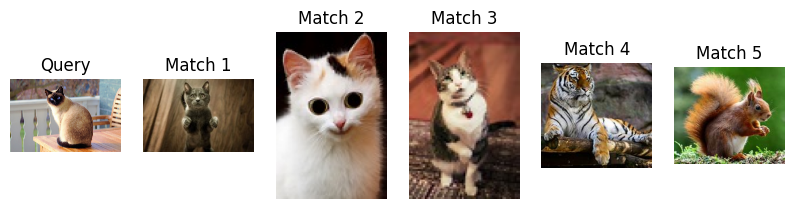

In [12]:
import os
import numpy as np
from PIL import Image
from torchvision import models, transforms
import torch
from annoy import AnnoyIndex
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval().to(device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Path to image folder
image_dir = 'dataset_images/'
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]

# Feature extraction
def extract_feature(image_path):
    image = Image.open(image_path).convert('RGB')
    img_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        feature = model(img_tensor).squeeze().cpu().numpy()
    return feature / np.linalg.norm(feature)




feature_size = 512
index = AnnoyIndex(feature_size, 'angular')

features = []
image_paths = []

for i, img_name in enumerate(image_files):
    path = os.path.join(image_dir, img_name)
    vec = extract_feature(path)
    index.add_item(i, vec)
    features.append(vec)
    image_paths.append(path)

index.build(10)
index.save('image_index.ann')

query_path = 'query.jpg'
query_vec = extract_feature(query_path)
index.load('image_index.ann')
ids = index.get_nns_by_vector(query_vec, 5)

def show_images(query_path, result_paths):
    plt.figure(figsize=(10, 3))
    plt.subplot(1, len(result_paths) + 1, 1)
    plt.imshow(Image.open(query_path))
    plt.title("Query")
    plt.axis('off')

    for i, path in enumerate(result_paths):
        plt.subplot(1, len(result_paths) + 1, i + 2)
        plt.imshow(Image.open(path))
        plt.title(f"Match {i+1}")
        plt.axis('off')
    plt.show()

result_images = [image_paths[i] for i in ids]
show_images(query_path, result_images)
